In [148]:
import functools
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
from scipy.spatial import ConvexHull
import string
import sys
import pneumodel.plotting as plotting
import pneumodel.trial as pn
import scipy.stats as st

In [2]:
%load_ext autoreload
%autoreload 2

##  Setup

In [174]:
%matplotlib inline
cubehelix = palettable.cubehelix.cubehelix1_16_r.mpl_colors
COLORS = '.6', '.25', 'k'

In [175]:
OUTPUTS_PATH = "/Volumes/Samsung USB/WCV-PAPER"
FIGURES_PATH = os.path.join(OUTPUTS_PATH, 'figures', 'sensitivity-analyses')
save_figure = functools.partial(plotting.save_figure, folder=FIGURES_PATH, dpi=300)

## Analysis

In [176]:
FOLDERS = (
  'wcv-trial-kenya',
  'wcv-trial-kenya-genpop-10K',
  'wcv-trial-kenya-genpop-50K',
  'wcv-trial-kenya-armsize-2.5K',
  'wcv-trial-kenya-armsize-10K',
  'wcv-trial-kenya-random-mixing'
)

In [177]:
%%time
TRJS = np.array([pn.load_trajectories(os.path.join(OUTPUTS_PATH, f), index_by='birth', max_runs=25) for f in FOLDERS])

CPU times: user 8.95 s, sys: 722 ms, total: 9.68 s
Wall time: 14.7 s


In [193]:
def plot_trajectories(axes, trjs, lgd_title, labels, months_since_birth=(1, 13, 1)):
  arm_names = np.array(['control-infant', 'dr-10ce-infant'])
  arm_labels = np.array(['controls', 'wSP 10 c.e. (infants)'])

  msb = np.arange(*months_since_birth) # months since birth

  for ax, arm_name, title in zip(axes, arm_names, arm_labels):
    ymin, ymax = 1, 0
    for i, trj in enumerate(trjs):
      for m in msb:
        ys = trj[arm_name].loc[m * 30]
        ymax = max(max(ys), ymax)
        ymin = min(min(ys), ymin)
        w = 0.25
        delta = (i - len(trjs) / 2) * w
        vp = ax.violinplot(ys, [m + delta], vert=True, widths=w,
                           showmeans=False, showextrema=True, showmedians=True)
        plotting.style_violin(vp, COLORS[i], 'k')

    #ax.set_title(title, fontsize=14)  
    ax.text(0.5, 0.1, title, ha='center', va='bottom', 
            transform=ax.transAxes, fontsize=16, alpha=0.8, fontweight='regular')

    ax.set_xlabel('Age (months)')
    ax.set_xlim(min(msb) - 0.5, max(msb) + 0.5)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

    ax.set_ylabel('Prevalence')
    ax.set_ylim(ymin * 0.98, ymax * 1.02)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

    plotting.remove_spines(ax)
    
  ax = axes[-1]
  patches = [mpl.patches.Patch(color=COLORS[i], label=l, alpha=0.5) for i, l in enumerate(labels)]
  lgd = ax.legend(handles=patches, title=lgd_title, frameon=True, fontsize=12, 
                  bbox_to_anchor=(1.05, 0.5), loc='center left')
  lgd.get_title().set_fontsize(14) 
    
  return lgd # returns extra artists

['/Volumes/Samsung USB/WCV-PAPER/figures/sensitivity-analyses/sensitivity-analysis-4.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/figures/sensitivity-analyses/sensitivity-analysis-4.png']

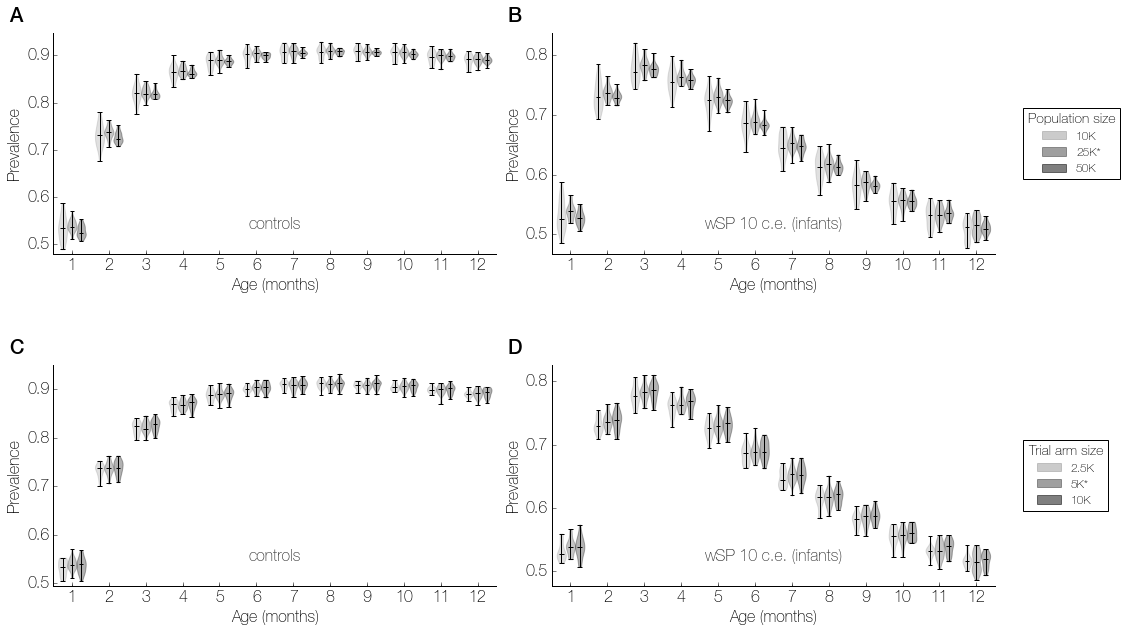

In [195]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8.5))

lgd1 = plot_trajectories(axes[0], TRJS[[1, 0, 2]], 'Population size', ['10K', '25K*', '50K'])
lgd2 = plot_trajectories(axes[1], TRJS[[3, 0, 4]], 'Trial arm size',  ['2.5K', '5K*', '10K'])

# add subplot labels
num_plots = len(axes.flatten())
labels = string.ascii_uppercase[:num_plots]
label_artists = []
for label, ax in zip(labels, axes.flatten()):
  t = ax.text(-0.1, 1.05, label, fontsize=20, 
              fontweight='medium', transform=ax.transAxes)
  label_artists.append(t)
  
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
save_figure(fig, 'sensitivity-analysis', bbox_inches='tight', bbox_extra_artist=[label_artists] + [lgd1, lgd2])